## Book Store Sales Prediction with RNN 

### License Statement 

In [ ]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""

### Steps to get the bookstore sales data 

Sales data from the United States Census Bureau can be obtained from https://www.census.gov/econ/currentdata.

Select Monthly Retail Trade and Food Services and click the Submit button. That should take you to a page where you need to specify five different steps. Select:

- Monthly Retail Trade and Food Services
- Start: 1992 End: 2020
- 451211: Book Stores
- Sales - Monthly
- U.S. Total

- Make sure that the checkbox Not Seasonally Adjusted is checked. 
- Then click the GET DATA button. That should result in a table with data values. 
- Download it to a comma-separated values (CSV) file by clicking the link TXT. 
- Remove the first few lines in the downloaded CSV file so the file starts with a single line containing headings saying "Period,Value" followed by one line for each month. 
- Further, remove any lines with non-numerical values, such as "NA", at the end of the file. - - Name the file book_store_sales.csv and copy to the data directory.

### Objective 

This code example demonstrates how to use a recurrent neural network to solve a time series prediction problem. The goal is to predict future sales data based on historical values. 


### Creating Training Data examples 

- We have HISTORY months’ worth of historical data, and we note that we can create at least one training example corresponding to each month. 

- For example, the value for the last month can result in a training example where the input data consists of a vector of length (HISTORY-1). 

- Similarly, the second month in the historical data can result in a training example where the input data consists of a vector of length 1 because there is only a single month preceding the second month of the season. 

- We also have the extreme case of the first historical month with a zero- length vector as input. 

- For the more recent months, such as the last month, we could create multiple training examples. For example, in addition to the preceding example, we can also do the same but use only the M days preceding the final day, where M < (HISTORY-1).

- We decide to create only a single training example from each month and to use as much history as possible for each training example. 

- We further decide that each training example should have at least MIN months of history. We will end up with (HISTORY-MIN) examples

- The length of the input ranges between MIN and (HISTORY-1).

### Imports and Data Read 

**Steps**
- First, we import modules that we need for the network. 
- We also load the data file into an array.
- We then split the data into training data (the first 80% of the data points) and test data (the remaining 20% of the months).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
import logging
tf.get_logger().setLevel(logging.ERROR)

EPOCHS = 100
BATCH_SIZE = 16
TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = 'book_store_sales.csv'

def readfile(file_name):
    file = open(file_name, 'r', encoding='utf-8')
    next(file)
    data = []
    for line in (file):
        values = line.split(',')
        data.append(float(values[1]))
    file.close()
    return np.array(data, dtype=np.float32)

# Read data and split into training and test data.
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]


In [4]:
## Dimension Check
print("Train Data Dimensions")
print(train_sales.shape)

print("Test Data Dimensions")
print(test_sales.shape)

Train Data Dimensions
(278,)
Test Data Dimensions
(70,)


#### Plot the  Historical Data 

**Key Observations**

The next code snippet plots the historical sales data. The data shows a clear seasonal pattern along with an indication that the overall trend in sales has changed over time, presumably due to increased online sales. The data starts in 1992 and ends in March 2020. The drop for the last month was likely caused by the COVID-19 pandemic hitting the United States.


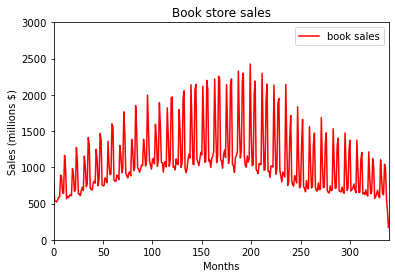

In [5]:
# Plot dataset
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (millions $)')
plt.legend()
plt.show()


###  Plot results from Naive Model :

Next month Sales = Value of previous month 

**KeyNotes**

For comparison purposes, create output corresponding to a naive model that predicts that the sales next month will be the same as the sales this month. Compare this to the correct data by plotting the values side by side.

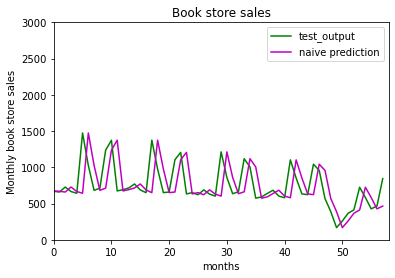

In [6]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()

#### Standardize data 

The next step is to standardize the data points by subtracting the mean and dividing by the standard deviation of the training examples.

In [14]:
# Standardize train and test data.
# Use only training seasons to compute mean and stddev.
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev

### Create training data 

**Key Notes**

- Number of Total Training data points = Length(Train_Sales) 
- MIN = Minimum history needed 
- Total X data points = total Train Data - MIN
- MAX Size of Each train data point Input vector = Total Number of Train points - 1

**Steps**
- Init with zeros X, Y Train data 
- Populate Y vector with Standardized values from original Y Data forwarded by 'MIN' Positions
- Populate the X data with varying length from the standardized X Data 

In [19]:
# Create training examples.
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1))
train_y = np.zeros((train_months-MIN, 1))
for i in range(0, train_months-MIN):
    train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
    train_y[i, 0] = train_sales_std[i+MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1))
test_y = np.zeros((test_months-MIN, 1))
for i in range(0, test_months-MIN):
    test_X[i, -(i+MIN):, 0] = test_sales_std[0:i+MIN]
    test_y[i, 0] = test_sales_std[i+MIN]


### Define RNN Architecture

We are finally ready to define and train our network. This is shown in the code snippet below.

In [20]:
# Create RNN model
model = Sequential()
model.add(SimpleRNN(128, activation='relu',input_shape=(None, 1)))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam',
              metrics =['mean_absolute_error'])
model.summary()
history = model.fit(train_X, train_y,
                    validation_data
                    = (test_X, test_y), epochs=EPOCHS,
                    batch_size=BATCH_SIZE, verbose=2,
                    shuffle=True)


NotImplementedError: Cannot convert a symbolic Tensor (simple_rnn_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

For comparison, create naive predictions based on standardized data.

In [ ]:
# Create naive prediction based on standardized data.
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)


To shed some light on how this affects the end behavior, let us use our newly trained model to do some predictions and then plot these predictions next to the actual values. The code snippet below demonstrates how this can be done. We first call model.predict with the test input as argument. The second argument is the batch size, and we state the length of the input tensor as the batch size (i.e., we ask it to do a prediction for all the input examples in parallel). During training, the batch size will affect the result, but for prediction, it should not affect anything except for possibly runtime. We could just as well have used 16 or 32 or some other value. The model will return a 2D array with the output values. Because each output value is a single value, a 1D array works just as well, and that is the format we want in order to enable plotting the data, so we call np.reshape to change the dimensions of the array. The network works with standardized data, so the output will not represent demand directly. We must first destandardize the data by doing the reverse operation compared to the standardization. That is, we multiply by the standard deviation and add the mean. We then plot the data.

In [ ]:
# Use trained model to predict the test data
predicted_test = model.predict(test_X, len(test_X))
predicted_test = np.reshape(predicted_test,
                            (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

# Plot test prediction.
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-',
         label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):],
         'g-', label='actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()
